# Libraries

In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import json, os
from sklearn.metrics import r2_score, root_mean_squared_error
import numpy as np
from pymatgen.io.ase import AseAtomsAdaptor
# Set the environment variable
os.environ["NEQUIP_ERROR_ON_NO_EDGES"] = "false"
# Verify that the environment variable is set
print(os.environ["NEQUIP_ERROR_ON_NO_EDGES"])  # Should output: false

from nequip.ase import NequIPCalculator
from ase.io import read, write

false


/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/nequip/__init__.py:20: UserWarning: !! PyTorch version 1.13.1 found. Upstream issues in PyTorch versions 1.13.* and 2.* have been seen to cause unusual performance degredations on some CUDA systems that become worse over time; see https://github.com/mir-group/nequip/discussions/311. The best tested PyTorch version to use with CUDA devices is 1.11; while using other versions if you observe this problem, an unexpected lack of this problem, or other strange behavior, please post in the linked GitHub issue.
  warnings.warn(


# Running the Code

In [8]:
# load in the data we used for testing
#test_data = read('w-14_test.xyz', index=':') # the index=':' reads in all the images in the file
#test_data = read('../data/db_W.xyz', index=':')
test_data = read('../data/w-14.xyz', index=':')

In [9]:
# now that we have loaded in the data, we need to specify the calculator

# first define the path to the machine learning model 
potential_path = '../Potentials/w-ef.pth'

# next define the species (elements) in the calculator 
species = {'W' : 'W'}

In [10]:
# define environment variables that suppress errors
os.environ['NEQUIP_ERROR_ON_NO_EDGES'] = 'false'


# define the calculator object
calculator = NequIPCalculator.from_deployed_model(
    model_path=potential_path,
    species=species,
    device='cpu'
)

/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/nequip/utils/_global_options.py:95: UserWarning: Do NOT manually set PYTORCH_JIT_USE_NNC_NOT_NVFUSER=0 unless you know exactly what you're doing!
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/nequip/ase/nequip_calculator.py:73: UserWarning: Trying to use chemical symbols as NequIP type names; this may not be correct for your model! To avoid this warning, please provide `species_to_type_name` explicitly.
  warnings.warn(


In [11]:
# next define the data structures
forces = []
energies = []
true_forces = []
true_energies = []

In [12]:
print(test_data[0].get_potential_energy())
print(test_data[0].arrays['force'].flatten())

-11.194835125297
[0. 0. 0.]


In [13]:
# run the evaluation loop
for i,atoms in enumerate(test_data):
    if i % 10 == 0:
        print(f'Calculating image {i}/{len(test_data)}')
    # get the true energy and forces
    true_energy = atoms.get_potential_energy()
    true_force = atoms.arrays['force'].flatten()
    true_forces.append(true_force)
    true_energies.append(true_energy)
    
    # set the calculator
    atoms.calc = calculator
    
    # get the predicted energy and forces
    pred_energy = atoms.get_potential_energy()
    pred_forces = atoms.get_forces()
    
    # append the results to the data structures
    energies.append(pred_energy)
    forces.append(pred_forces)

Calculating image 0/9693
Calculating image 10/9693
Calculating image 20/9693
Calculating image 30/9693
Calculating image 40/9693
Calculating image 50/9693
Calculating image 60/9693
Calculating image 70/9693
Calculating image 80/9693
Calculating image 90/9693
Calculating image 100/9693
Calculating image 110/9693
Calculating image 120/9693
Calculating image 130/9693
Calculating image 140/9693
Calculating image 150/9693
Calculating image 160/9693
Calculating image 170/9693
Calculating image 180/9693
Calculating image 190/9693
Calculating image 200/9693
Calculating image 210/9693
Calculating image 220/9693
Calculating image 230/9693
Calculating image 240/9693
Calculating image 250/9693
Calculating image 260/9693
Calculating image 270/9693
Calculating image 280/9693
Calculating image 290/9693
Calculating image 300/9693
Calculating image 310/9693
Calculating image 320/9693
Calculating image 330/9693
Calculating image 340/9693
Calculating image 350/9693
Calculating image 360/9693
Calculating 

In [24]:
# Massage the data structure into a numpy array
# Flatten the nested sequences in true_forces
true_forces_flat = [force for sublist in true_forces for force in sublist]

# Convert forces and true_forces to numpy arrays and flatten them
new_forces = np.concatenate(forces, axis=0).flatten()
new_true_forces = np.asarray(true_forces_flat).flatten()

# Convert energies and true_energies to numpy arrays
new_energies = np.asarray(energies)
new_true_energies = np.asarray(true_energies)

# Print the first element to verify
print(new_forces[0])
print(new_true_forces[0])

-0.0
0.0


In [26]:
# Debugging: Check the shapes of true_forces and forces
print(f'Shape of true_forces: {len(new_true_forces)}')
print(f'Shape of forces: {len(new_forces)}')

# Check the first few elements to see if they have consistent lengths
print(f'First element of true_forces: {new_true_forces[0]}')
print(f'First element of forces: {new_forces[0]}')

# Now that we have all the data in the data structures, we can calculate the R2 score
r2_energy = r2_score(new_true_energies, new_energies)
r2_forces = r2_score(new_true_forces, new_forces)
rmse_energy = root_mean_squared_error(new_true_energies, new_energies)
rmse_forces = root_mean_squared_error(new_true_forces, new_forces)

Shape of true_forces: 475578
Shape of forces: 475578
First element of true_forces: 0.0
First element of forces: -0.0


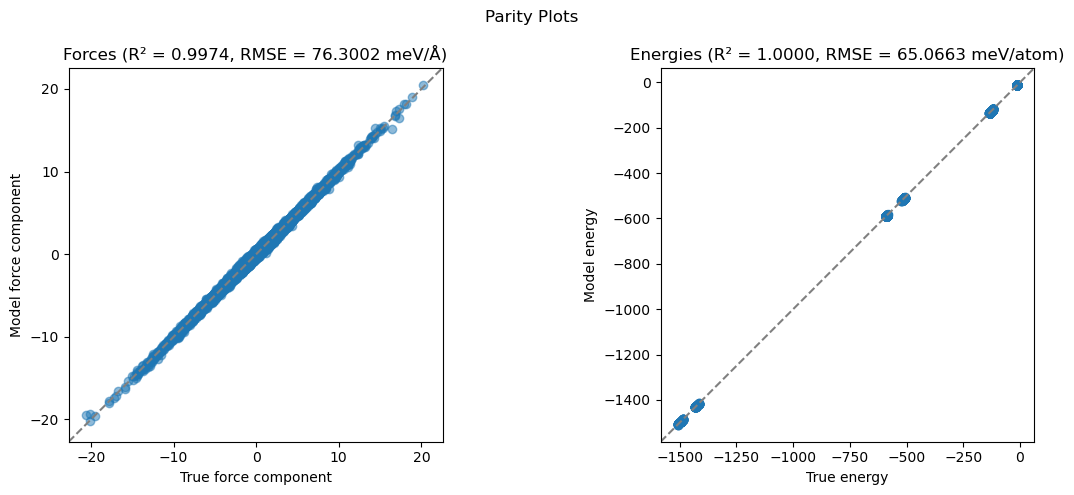

In [28]:
# this plots the results, the R2 score, and the Root mean squared error (RMSE)
n_plots = 2
fig_width = 12 

fig, axs = plt.subplots(ncols=n_plots, figsize=(fig_width, 5))

# Force plot
ax = axs[0]
ax.set_xlabel("True force component")
ax.set_ylabel("Model force component")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="gray")
ax.scatter(new_true_forces, new_forces, alpha=0.5)
# Ensure the plot is square by setting the same limits for x and y axes
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),  # min of both axes
    max(ax.get_xlim()[1], ax.get_ylim()[1]),  # max of both axes
]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')  # Ensure the aspect ratio is equal
ax.set_title(f"Forces (R² = {r2_forces:.4f}, RMSE = {1E3*rmse_forces:.4f} meV/Å)")

# Energy plot
ax = axs[1]
ax.set_xlabel("True energy")
ax.set_ylabel("Model energy")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="gray")
ax.scatter(new_true_energies, new_energies, alpha=0.5)
# Ensure the plot is square by setting the same limits for x and y axes
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),  # min of both axes
    max(ax.get_xlim()[1], ax.get_ylim()[1]),  # max of both axes
]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect("equal")
ax.set_title(f"Energies (R² = {r2_energy:.4f}, RMSE = {1E3*rmse_energy:.4f} meV/atom)")

plt.suptitle("Parity Plots")
plt.tight_layout()

plt.show()